In [49]:

import pandas as pd

In [50]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K


# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000]
test_data = data[20000:]

# Normalisation des données
scaler = StandardScaler()
train_data_x = scaler.fit_transform(train_data.drop(['anomaly', 'changepoint'], axis=1))
test_data_x = scaler.transform(test_data.drop(['anomaly', 'changepoint'], axis=1))
train_data_y = train_data[['anomaly']].values
test_data_y = test_data[['anomaly']].values


78/78 [==============================] - 0s 2ms/step


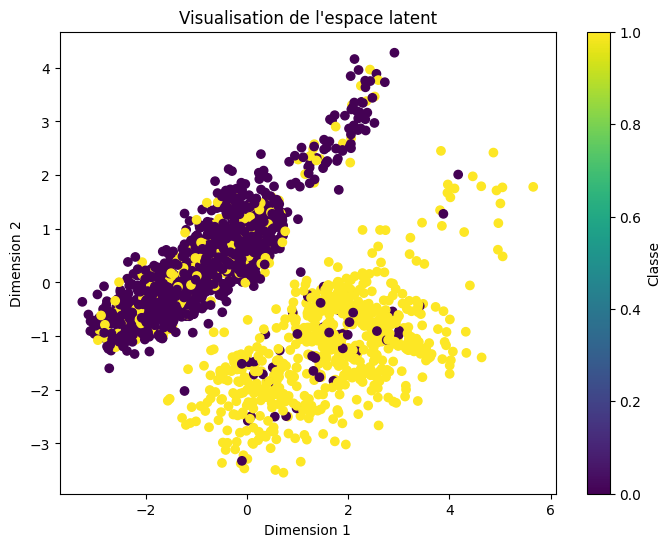

In [52]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import load_model


# Hypothèse : vous avez déjà entraîné votre modèle et vos prototypes
encoder_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model4.h5'
encoder = load_model(encoder_path)

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Tracer les points de l'espace latent
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=test_data_y[:, 0], cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent')
plt.colorbar(scatter, label='Classe')
plt.show()

78/78 [==============================] - 0s 2ms/step


/home/manuemk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


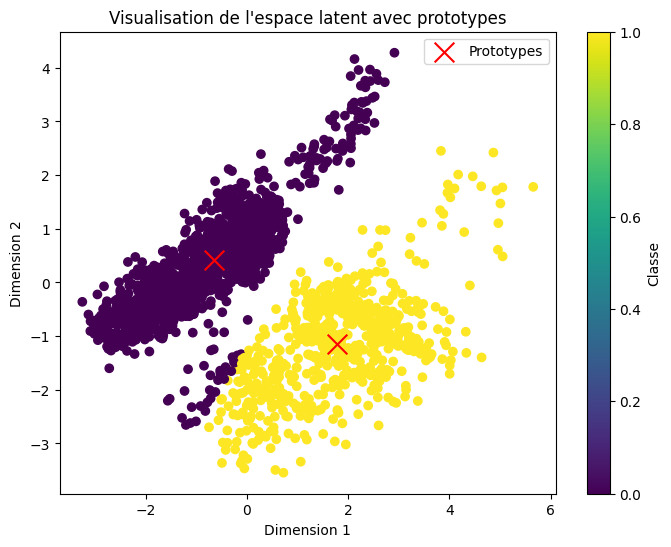

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_latent_2d)
prototypes_2d = kmeans.cluster_centers_

# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

In [54]:
print(prototypes_2d[0])

[-0.6555259  0.4268435]


In [55]:
# Projeter les prototypes dans l'espace latent de dimensionnalité initiale
prototypes = pca.inverse_transform(prototypes_2d[0])

print(prototypes)

[-1.6727176  0.0227344  1.3158953 -0.5994835]


78/78 [==============================] - 0s 2ms/step
Prototypes de taille 4 :
[[ 0.23994148 -1.7684474   0.9917884   0.61464906]
 [-1.6613375   0.03361005  1.3029205  -0.5999655 ]]


/home/manuemk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


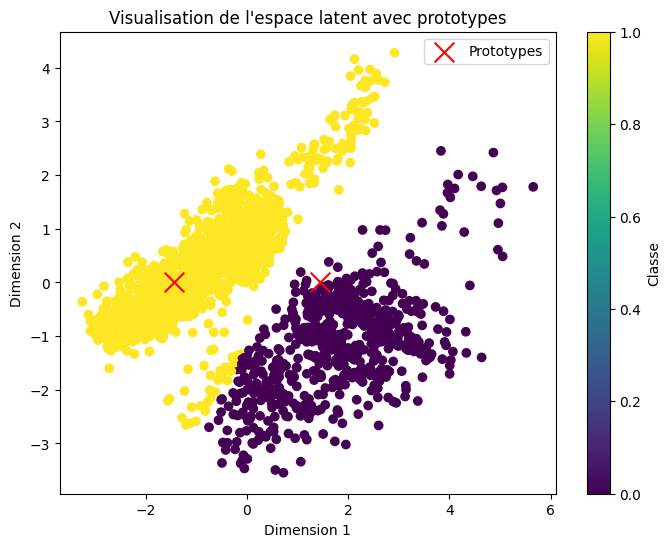

In [56]:
# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_latent)
prototypes = kmeans.cluster_centers_

print("Prototypes de taille", test_latent.shape[1], ":")
print(prototypes)


# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)
prototypes_2d = pca.fit_transform(prototypes)

# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

In [57]:
import pandas as pd
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/other/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files ]


# Concaténer les datasets en un seul DataFrame
test = pd.concat(list_of_df)
test = test.iloc[:10000,:]

# Afficher le résultat
print(test)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 18:10:42           0.240983           0.287449  2.879000  0.054711   
2020-02-08 18:10:43           0.241153           0.285669  2.696420  0.054711   
2020-02-08 18:10:44           0.246551           0.287455  2.582570  0.382638   
2020-02-08 18:10:45           0.238680           0.282037  2.207200  0.382638   
2020-02-08 18:10:46           0.238926           0.285487  0.936421  0.382638   
...                                ...                ...       ...       ...   
2020-03-01 16:46:33           0.080688           0.131922  1.745770  0.054711   
2020-03-01 16:46:35           0.080954           0.131856  1.649030  0.054711   
2020-03-01 16:46:36           0.080249           0.135997  1.683600  0.054711   
2020-03-01 16:46:37           0.081576           0.133341  0.808510  0.382638   
2020-03-01 16:46:38         

In [58]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
print(X)
print(y[:10])


[[-0.15470175 -0.17561072  0.98110401 ...  0.91511187  1.01520097
   0.37864219]
 [-0.15345788 -0.18781099  0.64289851 ...  0.91654318 -0.77365192
   0.4110445 ]
 [-0.11396124 -0.17556959  0.43200632 ...  0.91830165 -0.04263604
   0.39336197]
 ...
 [-1.33077594 -1.21367538 -1.23321769 ... -2.87377636 -0.41144428
  -2.01978718]
 [-1.32106494 -1.23187983 -2.85420713 ... -2.87676167  0.68077083
  -2.01978718]
 [-1.32695139 -1.24371683 -1.09625354 ... -2.8742671  -0.53291356
  -2.01978718]]
datetime
2020-02-08 18:10:42    False
2020-02-08 18:10:43    False
2020-02-08 18:10:44    False
2020-02-08 18:10:45    False
2020-02-08 18:10:46    False
2020-02-08 18:10:47    False
2020-02-08 18:10:48    False
2020-02-08 18:10:49    False
2020-02-08 18:10:50    False
2020-02-08 18:10:51    False
Name: anomaly, dtype: bool


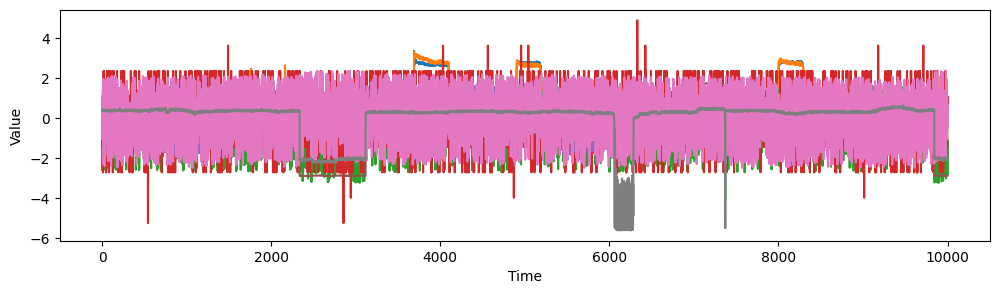

In [59]:
# Tracer la série temporelle
plt.figure(figsize=(12, 3))
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [60]:
X = X[:10, :]
y = y[:10]
print(X)

[[-0.15470175 -0.17561072  0.98110401 -0.17558487 -0.91891377  0.91511187
   1.01520097  0.37864219]
 [-0.15345788 -0.18781099  0.64289851 -0.17558487 -0.91244237  0.91654318
  -0.77365192  0.4110445 ]
 [-0.11396124 -0.17556959  0.43200632  1.09492803 -0.82514728  0.91830165
  -0.04263604  0.39336197]
 [-0.17155258 -0.21270502 -0.26331737  1.09492803 -0.87767579  0.91830165
   0.27217567  0.44349384]
 [-0.16975262 -0.18905843 -2.61726878  1.09492803 -0.71905758  0.92492658
  -1.06655332  0.40817579]
 [-0.18457666 -0.22961404 -0.19246426 -0.17558487 -0.90287295  0.92447674
   0.1342049   0.4110445 ]
 [-0.13808507 -0.17421248  0.62746828 -1.44609778 -0.95829295  0.92942499
   0.56856071  0.37864219]
 [-0.15872605 -0.19639915  0.50902781  1.09492803 -0.8351986   0.92386332
   0.02905376  0.4110445 ]
 [-0.15339202 -0.17343112  0.40536925 -0.17558487 -0.82321962  0.92913873
  -0.13302752  0.42567022]
 [-0.18344986 -0.21006619  0.3698223   1.09492803 -0.98211321  0.92165501
   1.42911327  0.

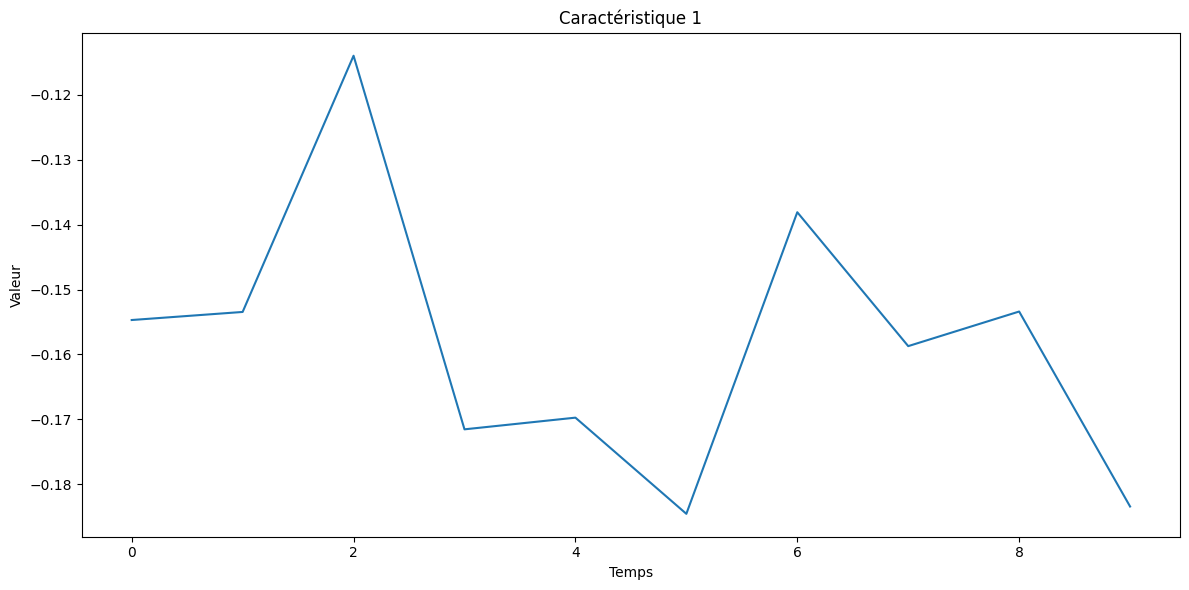

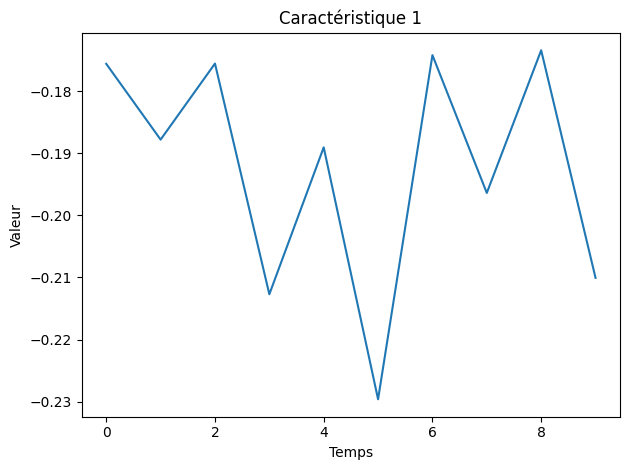

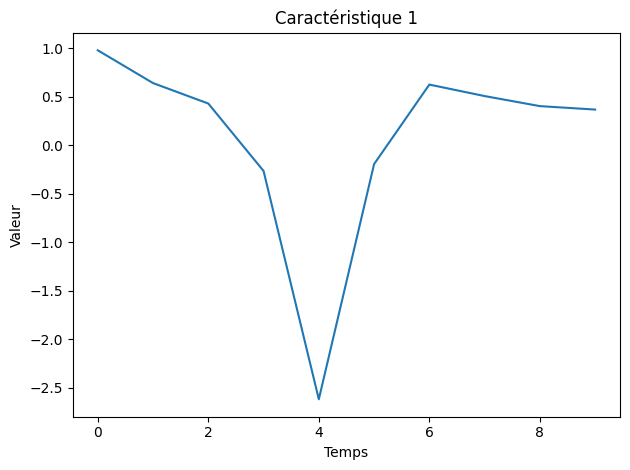

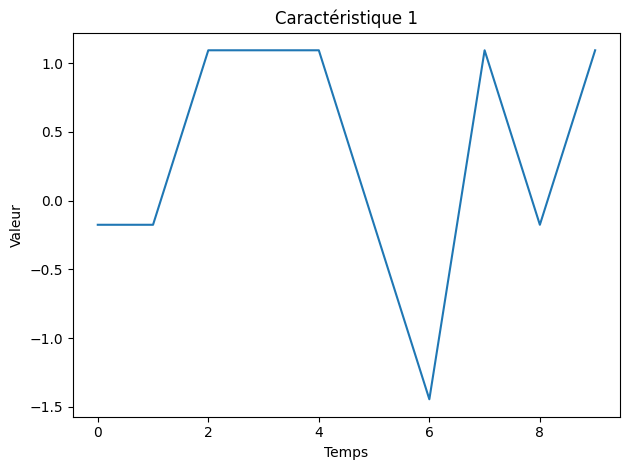

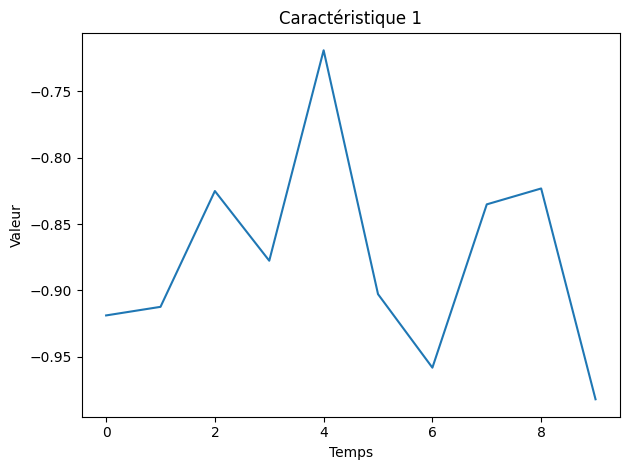

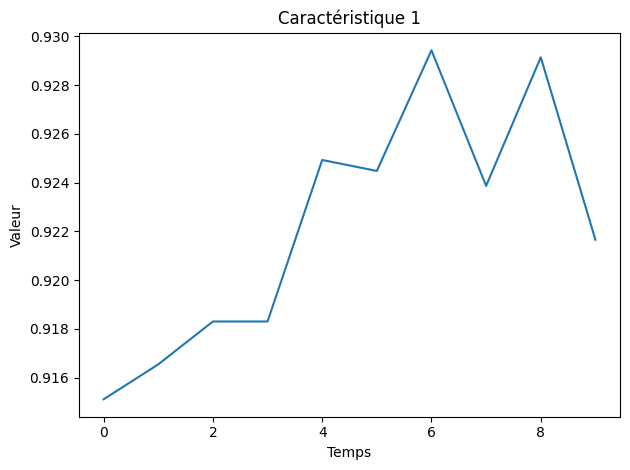

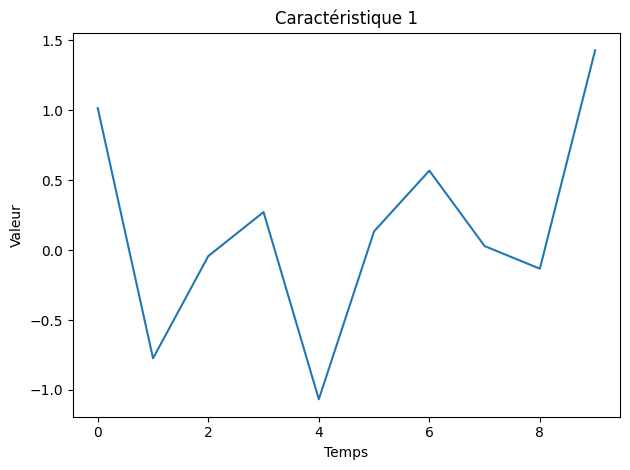

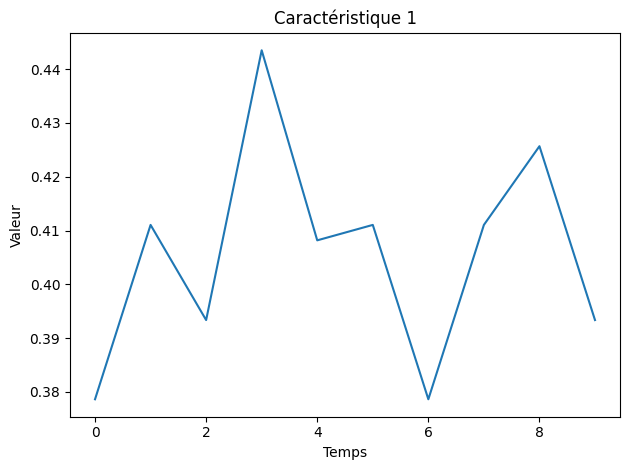

In [61]:
import numpy as np
import matplotlib.pyplot as plt


# Tracer chaque caractéristique séparément
plt.figure(figsize=(12, 6))

for i in range(8):
    #plt.subplot(1, 3, 1)
    plt.plot(X[ :, i])
    plt.title('Caractéristique 1')
    plt.xlabel('Temps')
    plt.ylabel('Valeur')
    plt.tight_layout()
    plt.show()




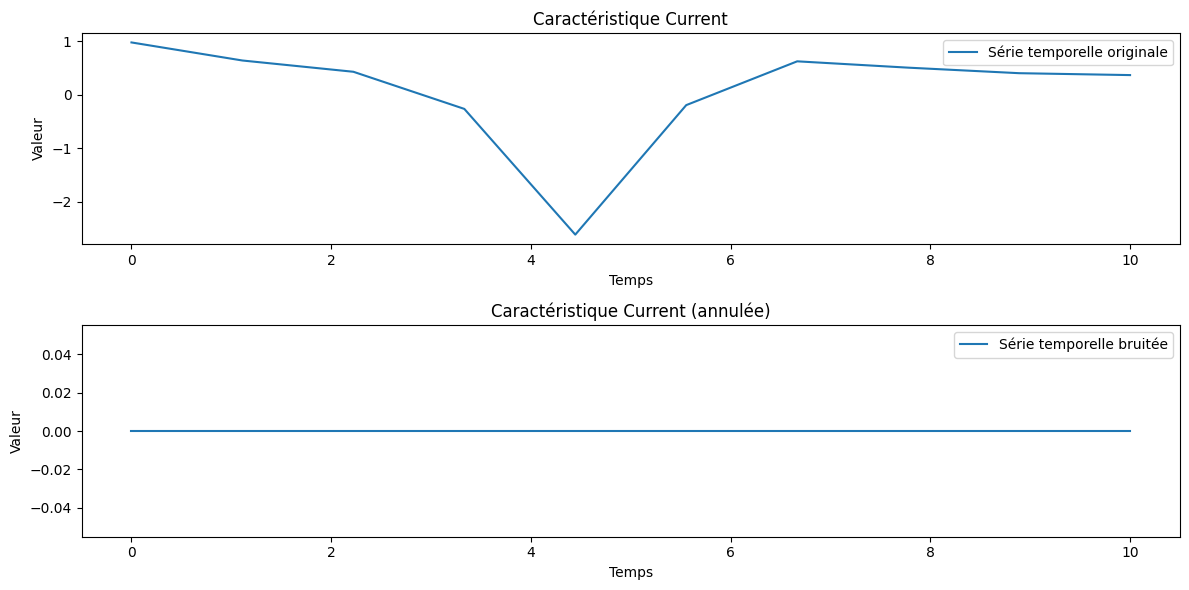

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Génération d'une série temporelle multidimensionnelle
t = np.linspace(0, 10, 10)
# X = np.column_stack((np.sin(2 * np.pi * t), np.cos(2 * np.pi * t), np.exp(t/5)))

# Sélection d'une caractéristique à bruiter
feature_index = 2  # Bruiter la 2ème caractéristique (index commence à 0)
noise_amplitude = 0.8  # Amplitude du bruit

# Ajout de bruit à la caractéristique sélectionnée
X_noisy = X.copy()
X_noisy[:, 2] = 0
# Affichage des séries temporelles originale et bruitée
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, X[:, feature_index], label='Série temporelle originale')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.title(f'Caractéristique Current')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, X_noisy[:, feature_index], label='Série temporelle bruitée')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.title(f'Caractéristique Current (annulée)')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
print(X_noisy)

[[-0.15470175 -0.17561072  0.         -0.17558487 -0.91891377  0.91511187
   1.01520097  0.37864219]
 [-0.15345788 -0.18781099  0.         -0.17558487 -0.91244237  0.91654318
  -0.77365192  0.4110445 ]
 [-0.11396124 -0.17556959  0.          1.09492803 -0.82514728  0.91830165
  -0.04263604  0.39336197]
 [-0.17155258 -0.21270502  0.          1.09492803 -0.87767579  0.91830165
   0.27217567  0.44349384]
 [-0.16975262 -0.18905843  0.          1.09492803 -0.71905758  0.92492658
  -1.06655332  0.40817579]
 [-0.18457666 -0.22961404  0.         -0.17558487 -0.90287295  0.92447674
   0.1342049   0.4110445 ]
 [-0.13808507 -0.17421248  0.         -1.44609778 -0.95829295  0.92942499
   0.56856071  0.37864219]
 [-0.15872605 -0.19639915  0.          1.09492803 -0.8351986   0.92386332
   0.02905376  0.4110445 ]
 [-0.15339202 -0.17343112  0.         -0.17558487 -0.82321962  0.92913873
  -0.13302752  0.42567022]
 [-0.18344986 -0.21006619  0.          1.09492803 -0.98211321  0.92165501
   1.42911327  0.

In [64]:
# Chargement du modèle
decoder_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/decoder_model4.h5'
decoder = load_model(decoder_path)

# Vérifier la forme des prototypes
print(f"Forme des prototypes : {prototypes.shape}")

# Ajouter une dimension supplémentaire aux prototypes
if len(prototypes.shape) == 1:
    prototypes = prototypes[None, :]

# Prédiction avec le décodeur
proto = decoder.predict(prototypes)
print(proto)

Forme des prototypes : (2, 4)
1/1 [==============================] - 0s 109ms/step
[[ 0.25172892 -0.5900803  -0.15772018  0.01039229 -0.64933264 -0.96168745
   0.748611   -0.9374204 ]
 [ 0.46575505 -0.7522196   0.01337088  0.1717694  -0.8658073  -1.2111644
  -0.09934685  0.4999475 ]]


In [65]:
# Chargement du modèle
model_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5'
vae = load_model(model_path)



In [66]:
X_pred = vae.predict(X)
print(X_pred)

1/1 [==============================] - 0s 246ms/step
[[-0.34366003 -0.26985723  1.1910907   0.08688115  0.2031602   0.5429227
   0.9798975   0.40568   ]
 [-0.22165924 -0.20902555  0.7607891   0.11037831  0.20875376  0.46488678
  -0.93915236  0.3891502 ]
 [-0.29215404 -0.21318047  0.250089    1.1332346   0.21850616  0.5388738
  -0.00419746  0.39811546]
 [-0.3305764  -0.32816586  0.09561805  0.99920475  0.16460758  0.45274013
   0.4519085   0.4079758 ]
 [-0.32875603 -0.29359633 -1.2885643   1.2468394   0.16383749  0.42140806
  -1.4136496   0.37846118]
 [-0.354957   -0.27879354 -0.00406125 -0.01168926  0.13372335  0.45527923
   0.33310917  0.409433  ]
 [-0.29531765 -0.26565945  1.0675954  -1.0566539   0.18420357  0.48232174
   0.56677544  0.43451923]
 [-0.3316189  -0.21614683  0.24308643  1.1369562   0.22091025  0.5579855
   0.02621128  0.3960051 ]
 [-0.27910858 -0.22446933  0.85383266  0.06634744  0.20312068  0.48195034
  -0.5270339   0.39100927]
 [-0.3868731  -0.14183241 -0.13118935  1.

In [67]:
from tensorflow.keras.losses import mse

reconstruction_error = mse(X_pred, X)
print(reconstruction_error)

tf.Tensor(
[0.19464033 0.19871483 0.16280083 0.18916062 0.37239203 0.17850616
 0.23584851 0.16902998 0.21098182 0.22246946], shape=(10,), dtype=float64)


In [68]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

In [69]:
recons_df['y_pred'] = recons_df['error'] > 0.25
recons_df

,error,y_true,y_pred
0,0.194640,False,False
1,0.198715,False,False
2,0.162801,False,False
3,0.189161,False,False
4,0.372392,False,True
5,0.178506,False,False
6,0.235849,False,False
7,0.169030,False,False
8,0.210982,False,False
9,0.222469,False,False


In [70]:
Xn_pred = vae.predict(X_noisy)
print(Xn_pred)

1/1 [==============================] - 0s 50ms/step
[[-3.20102990e-01 -1.97390556e-01 -2.71747559e-01 -3.99259478e-02
   1.31943017e-01  4.53605175e-01  1.17171156e+00  4.10443187e-01]
 [-2.44947746e-01 -2.04335570e-01  1.96488798e-01  3.18735689e-02
   1.92542821e-01  4.83328044e-01 -3.78235191e-01  4.09543514e-01]
 [-2.33571634e-01 -2.39954293e-01  1.94427311e-01  1.03603256e+00
   1.91727132e-01  4.77682769e-01  1.26011282e-01  4.06975210e-01]
 [-3.37446451e-01 -3.00777704e-01  1.19238757e-01  1.06365871e+00
   1.76047951e-01  4.78425145e-01  4.12544876e-01  4.04931486e-01]
 [-3.70409012e-01 -1.63124114e-01 -1.18760180e+00  1.18241537e+00
   1.98212594e-01  5.27616918e-01 -1.13122141e+00  3.72498095e-01]
 [-3.64649177e-01 -2.77322710e-01  3.75262648e-03  1.42877847e-02
   1.39478862e-01  4.65612411e-01  3.10592562e-01  4.07877982e-01]
 [-2.89895475e-01 -1.11931115e-01 -3.31810921e-01 -1.13925207e+00
   1.24937557e-01  4.48620617e-01  8.38924348e-01  4.10282969e-01]
 [-3.08338881e-01

In [71]:
from tensorflow.keras.losses import mse

reconstruction_error = mse(Xn_pred, X)
print(reconstruction_error)

tf.Tensor(
[0.36983345 0.22699855 0.16689629 0.18845252 0.38715396 0.17967892
 0.31499438 0.1750971  0.17339333 0.24385707], shape=(10,), dtype=float64)


In [72]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

In [73]:
recons_df['y_pred'] = recons_df['error'] > 0.25
recons_df

,error,y_true,y_pred
0,0.369833,False,True
1,0.226999,False,False
2,0.166896,False,False
3,0.188453,False,False
4,0.387154,False,True
5,0.179679,False,False
6,0.314994,False,True
7,0.175097,False,False
8,0.173393,False,False
9,0.243857,False,False


In [74]:
print(X_noisy[7, :])

[-0.15872605 -0.19639915  0.          1.09492803 -0.8351986   0.92386332
  0.02905376  0.4110445 ]


In [75]:
import tensorflow as tf
import numpy as np

def arcana_proto(x, x_prot, ae_model, alpha=0.8):
    """
    Implement the ARCANA algorithm to find the features that contributed to an anomaly.

    Args:
        x (np.ndarray): The input feature vector.
        x_prot (np.ndarray): The prototype sequence.
        ae_model (tf.keras.Model): The trained autoencoder model.
        alpha (float): Hyperparameter controlling the trade-off between reconstruction error and sparsity of the bias vector.

    Returns:
        x_bias (np.ndarray): The bias vector representing the deviation of each feature causing the anomaly.
        feature_importances (np.ndarray): The normalized absolute values of the bias vector, representing the feature importances.
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x_prot = tf.convert_to_tensor(x_prot, dtype=tf.float32)

    # Ensure x has shape (1, 8) if it's not already
    if x.shape.rank == 2 and x.shape[0] == 1:
        x = tf.squeeze(x, axis=0)
    x = tf.expand_dims(x, axis=0)

    with tf.GradientTape() as tape:
        x_corrected = x + tf.Variable(tf.zeros_like(x), name='x_bias', dtype=tf.float32)
        reconstruction = ae_model(x_corrected)[0]

        # Ensure x_prot has the same shape as reconstruction
        if x_prot.shape != reconstruction.shape:
            x_prot = tf.broadcast_to(x_prot, reconstruction.shape)

        # Calculate the loss function
        loss_reconstruction = tf.reduce_mean(tf.square(x_prot - reconstruction))
        loss_sparsity = tf.reduce_mean(tf.abs(x_prot - x))
        loss = (1 - alpha) * loss_reconstruction + alpha * loss_sparsity

    # Calculate the gradients of the loss function with respect to the bias vector
    gradients = tape.gradient(loss, x_corrected)

    # Update the bias vector using the gradients
    x_bias = -gradients.numpy()[0]
    feature_importances = tf.math.l2_normalize(tf.abs(x_bias), axis=0).numpy()

    return x_bias, feature_importances

In [76]:
prototype_sequences = [-0.17155258, -0.21270502, -0.26331737,  1.09492803, -0.87767579,  0.91830165,
   0.27217567,  0.44349384]

In [77]:
# Définir une variable globale pour stocker les biais
x_biases = []
feature_importances_proto = []


x = [[-0.15872605, -0.19639915,  0.,          1.09492803, -0.8351986,   0.92386332,
  0.02905376,  0.4110445 ]]
print(x) # Your input feature vector
ae_model = vae # Your trained autoencoder model

#for i in range(3):
x_bias, feature_importance = arcana_proto(x, prototype_sequences, ae_model, alpha=0.8)
x_biases.append(x_bias)
feature_importances_proto.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances_proto)

[[-0.15872605, -0.19639915, 0.0, 1.09492803, -0.8351986, 0.92386332, 0.02905376, 0.4110445]]
Bias vector: [array([ 0.00186403,  0.00069433, -0.00251156, -0.00142986,  0.00081256,
       -0.00138793,  0.0090652 , -0.00022785], dtype=float32)]
Feature importances: [array([0.18914126, 0.07045271, 0.25484562, 0.14508608, 0.08244992,
       0.14083232, 0.91983664, 0.02311955], dtype=float32)]


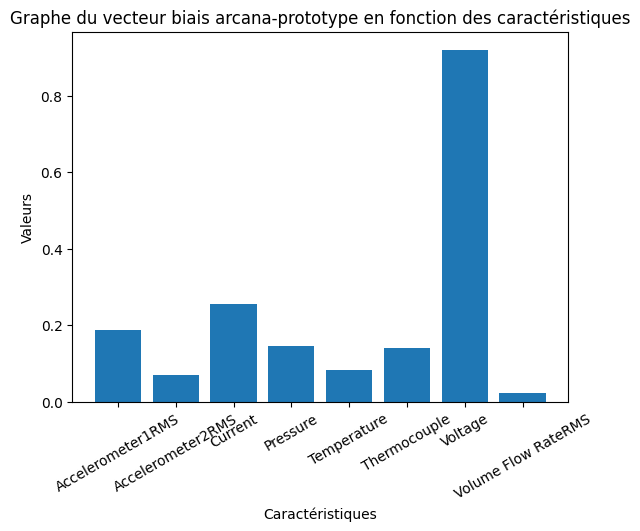

In [78]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances_proto[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur biais arcana-prototype en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [79]:
import tensorflow as tf
import numpy as np

def arcana_proto(x, x_prot, ae_model, alpha=0.8):
    """
    Implement the ARCANA algorithm to find the features that contributed to an anomaly.

    Args:
        x (np.ndarray): The input feature vector.
        ae_model (tf.keras.Model): The trained autoencoder model.
        alpha (float): Hyperparameter controlling the trade-off between reconstruction error and sparsity of the bias vector.

    Returns:
        x_bias (np.ndarray): The bias vector representing the deviation of each feature causing the anomaly.
        feature_importances (np.ndarray): The normalized absolute values of the bias vector, representing the feature importances.
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=0)

    with tf.GradientTape() as tape:
        x_corrected = x + tf.Variable(tf.zeros_like(x), name='x_bias', dtype=tf.float32)
        reconstruction = ae_model(x_corrected)[0]

        # Calculate the loss function
        loss_reconstruction = tf.reduce_mean(tf.square(x_prot - reconstruction))
        loss_sparsity = tf.reduce_mean(tf.abs(x_corrected - x))
        loss = (1 - alpha) * loss_reconstruction + alpha * loss_sparsity

    # Calculate the gradients of the loss function with respect to the bias vector
    gradients = tape.gradient(loss, x_corrected)

    # Update the bias vector using the gradients
    x_bias = -gradients.numpy()[0]
    feature_importances = tf.math.l2_normalize(tf.abs(x_bias), axis=0).numpy()

    return x_bias, feature_importances

# Assuming you have a trained autoencoder model and a sample input feature vector



# Example usage
x = [-0.15872605, -0.19639915,  0. ,         1.09492803, -0.8351986,   0.92386332,
  0.02905376,  0.4110445 ]
print(x)  # Your input feature vector
ae_model = vae  # Your trained autoencoder model

for i in range(3):
    x_bias, feature_importance = arcana_proto(x, prototype_sequences, ae_model, alpha=0.8)
    x_biases.append(x_bias)
    feature_importances_proto.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances_proto)

[-0.15872605, -0.19639915, 0.0, 1.09492803, -0.8351986, 0.92386332, 0.02905376, 0.4110445]
Bias vector: [array([ 0.00186403,  0.00069433, -0.00251156, -0.00142986,  0.00081256,
       -0.00138793,  0.0090652 , -0.00022785], dtype=float32), array([ 0.00198485,  0.00087097, -0.00250521, -0.00121843,  0.00083348,
       -0.00139101,  0.00934253, -0.00030685], dtype=float32), array([ 0.00170823,  0.00052765, -0.00273038, -0.00152864,  0.00084954,
       -0.00144722,  0.00987233, -0.00029928], dtype=float32), array([ 0.00206548,  0.00150597, -0.00235928, -0.00063602,  0.00091594,
       -0.0011112 ,  0.00968605, -0.00054037], dtype=float32)]
Feature importances: [array([0.18914126, 0.07045271, 0.25484562, 0.14508608, 0.08244992,
       0.14083232, 0.91983664, 0.02311955], dtype=float32), array([0.19608232, 0.08604324, 0.247489  , 0.12036832, 0.08233874,
       0.13741747, 0.9229447 , 0.0303138 ], dtype=float32), array([0.16044356, 0.04955933, 0.2564481 , 0.14357565, 0.07979247,
       0.135

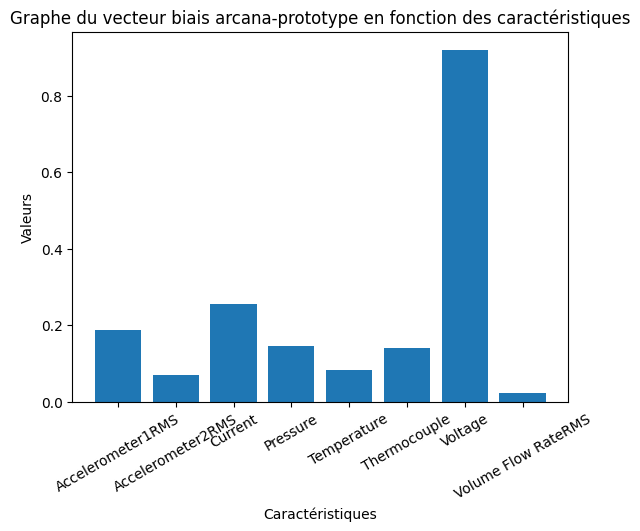

In [80]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances_proto[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur biais arcana-prototype en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [81]:
import tensorflow as tf
import numpy as np

def arcana(x, ae_model, alpha=0.8):
    """
    Implement the ARCANA algorithm to find the features that contributed to an anomaly.

    Args:
        x (np.ndarray): The input feature vector.
        ae_model (tf.keras.Model): The trained autoencoder model.
        alpha (float): Hyperparameter controlling the trade-off between reconstruction error and sparsity of the bias vector.

    Returns:
        x_bias (np.ndarray): The bias vector representing the deviation of each feature causing the anomaly.
        feature_importances (np.ndarray): The normalized absolute values of the bias vector, representing the feature importances.
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=0)

    with tf.GradientTape() as tape:
        x_corrected = x + tf.Variable(tf.zeros_like(x), name='x_bias', dtype=tf.float32)
        reconstruction = ae_model(x_corrected)[0]

        # Calculate the loss function
        loss_reconstruction = tf.reduce_mean(tf.square(x_corrected - reconstruction))
        loss_sparsity = tf.reduce_mean(tf.abs(x_corrected - x))
        loss = (1 - alpha) * loss_reconstruction + alpha * loss_sparsity

    # Calculate the gradients of the loss function with respect to the bias vector
    gradients = tape.gradient(loss, x_corrected)

    # Update the bias vector using the gradients
    x_bias = -gradients.numpy()[0]
    feature_importances = tf.math.l2_normalize(tf.abs(x_bias), axis=0).numpy()

    return x_bias, feature_importances

# Assuming you have a trained autoencoder model and a sample input feature vector



In [82]:
# Example usage
x = [-0.15872605, -0.19639915,  0.,          1.09492803, -0.8351986,   0.92386332,
  0.02905376,  0.4110445 ]
print(x)  # Your input feature vector
ae_model = vae  # Your trained autoencoder model
feature_importances = []

for i in range(3):
    x_bias, feature_importance = arcana(x,  ae_model, alpha=0.8)
    x_biases.append(x_bias)
    feature_importances.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances)

[-0.15872605, -0.19639915, 0.0, 1.09492803, -0.8351986, 0.92386332, 0.02905376, 0.4110445]
Bias vector: [array([ 0.00186403,  0.00069433, -0.00251156, -0.00142986,  0.00081256,
       -0.00138793,  0.0090652 , -0.00022785], dtype=float32), array([ 0.00198485,  0.00087097, -0.00250521, -0.00121843,  0.00083348,
       -0.00139101,  0.00934253, -0.00030685], dtype=float32), array([ 0.00170823,  0.00052765, -0.00273038, -0.00152864,  0.00084954,
       -0.00144722,  0.00987233, -0.00029928], dtype=float32), array([ 0.00206548,  0.00150597, -0.00235928, -0.00063602,  0.00091594,
       -0.0011112 ,  0.00968605, -0.00054037], dtype=float32), array([-0.00409546, -0.00079085,  0.01000902, -0.00204862,  0.05141004,
       -0.02148066,  0.00423854,  0.00022286], dtype=float32), array([-0.00399382, -0.00069007,  0.00985375, -0.00205869,  0.05157613,
       -0.0214473 ,  0.00423372,  0.00062749], dtype=float32), array([-0.00405378, -0.00077507,  0.0099202 , -0.00208005,  0.0514949 ,
       -0.021

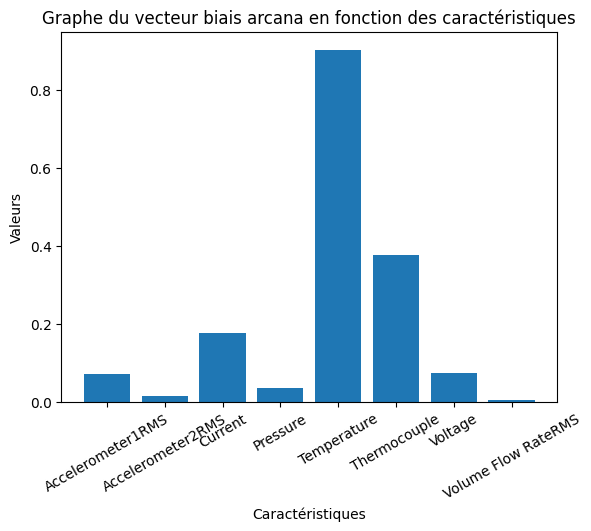

In [83]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur biais arcana en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [84]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
testt = X[900:910]
y_test = y[900:910]
print(X)
print(y[900:910])


[[-0.15470175 -0.17561072  0.98110401 ...  0.91511187  1.01520097
   0.37864219]
 [-0.15345788 -0.18781099  0.64289851 ...  0.91654318 -0.77365192
   0.4110445 ]
 [-0.11396124 -0.17556959  0.43200632 ...  0.91830165 -0.04263604
   0.39336197]
 ...
 [-1.33077594 -1.21367538 -1.23321769 ... -2.87377636 -0.41144428
  -2.01978718]
 [-1.32106494 -1.23187983 -2.85420713 ... -2.87676167  0.68077083
  -2.01978718]
 [-1.32695139 -1.24371683 -1.09625354 ... -2.8742671  -0.53291356
  -2.01978718]]
datetime
2020-02-08 18:26:29    True
2020-02-08 18:26:30    True
2020-02-08 18:26:32    True
2020-02-08 18:26:33    True
2020-02-08 18:26:34    True
2020-02-08 18:26:35    True
2020-02-08 18:26:36    True
2020-02-08 18:26:37    True
2020-02-08 18:26:38    True
2020-02-08 18:26:39    True
Name: anomaly, dtype: bool


In [85]:
X_pred = vae.predict(testt)
print(X_pred)

1/1 [==============================] - 0s 29ms/step
[[-2.3015042e-01 -5.3591155e-02  4.9629679e-01 -1.3355494e+00
  -3.6333624e-01 -4.3190873e-01 -1.3905638e+00  4.8918808e-01]
 [-1.6110513e-01  1.2256636e-02  8.5803992e-01  3.8749561e-02
  -3.4066427e-01 -4.3707740e-01 -2.5465366e-01  4.9997389e-01]
 [-2.0781827e-01  4.0907227e-02  1.0208108e+00  2.6038572e-02
  -3.5256603e-01 -4.4384325e-01  4.1314939e-01  5.0857610e-01]
 [-3.9075828e-01  3.2782461e-04  1.1368582e+00  6.5516278e-02
  -4.4912469e-01 -5.4559231e-01  8.2064235e-01  5.3215730e-01]
 [-2.3583923e-01  1.1525264e-01  2.3700394e-02  1.1206776e+00
  -4.6715719e-01 -5.6281471e-01  2.5505009e-01  5.2775925e-01]
 [-2.0097008e-01  5.0066635e-02  1.3487366e+00  1.0412266e+00
  -3.9367890e-01 -4.7934324e-01  1.4683719e+00  5.1440233e-01]
 [-2.8811085e-01  1.6173646e-02  1.2042094e-01 -3.1443164e-02
  -4.4391149e-01 -5.3375238e-01 -5.3858244e-01  5.2158839e-01]
 [-3.5486627e-01  1.0959967e-02  4.3604650e-02 -8.3408207e-03
  -4.903654

In [86]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

In [87]:
recons_df['y_pred'] = recons_df['error'] > 0.25
recons_df

,error,y_true,y_pred
0,0.369833,True,True
1,0.226999,True,False
2,0.166896,True,False
3,0.188453,True,False
4,0.387154,True,True
5,0.179679,True,False
6,0.314994,True,True
7,0.175097,True,False
8,0.173393,True,False
9,0.243857,True,False


In [88]:
print(testt[7, :])
print(y_test[7])

[-0.22496596 -0.12444498 -0.19729894 -0.17558487 -1.61039004  0.3268016
 -0.47094131  0.41109153]
True


In [89]:
# Définir une variable globale pour stocker les biais
x_biases = []
feature_importances_proto = []


x = [-0.22496596, -0.12444498, -0.19729894, -0.17558487, -1.61039004,  0.3268016,
 -0.47094131,  0.41109153]
print(x) # Your input feature vector
ae_model = vae # Your trained autoencoder model

#for i in range(3):
x_bias, feature_importance = arcana_proto(x, prototype_sequences, ae_model, alpha=0.8)
x_biases.append(x_bias)
feature_importances_proto.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances_proto)

[-0.22496596, -0.12444498, -0.19729894, -0.17558487, -1.61039004, 0.3268016, -0.47094131, 0.41109153]


Bias vector: [array([ 0.01821167, -0.00015963,  0.00278337,  0.02884208,  0.00515922,
        0.02281312,  0.02876781, -0.01045551], dtype=float32)]
Feature importances: [array([0.35342386, 0.00309781, 0.05401534, 0.55972254, 0.10012209,
       0.44272178, 0.55828106, 0.20290431], dtype=float32)]


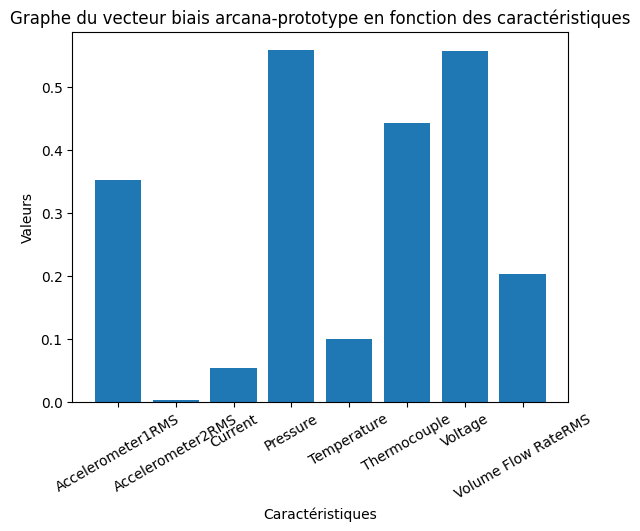

In [90]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances_proto[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur biais arcana-prototype en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [91]:
import numpy as np

# Données d'entrée
input_data = np.array([0, -0.12444498, -0.19729894, 0, -1.61039004,  0,
 0,  0.41109153])
#labels = np.array([64])

# Mise en forme des données pour l'autoencoder
input_data = np.expand_dims(input_data, axis=0)  # Ajouter une dimension de batch
vae.predict(input_data)

reconstructions = vae.predict(input_data)
reconstruction_error = mse(reconstructions, input_data)
pred = reconstruction_error > 0.25
print(reconstruction_error, pred)

1/1 [==============================] - 0s 27ms/step
tf.Tensor([0.22392096], shape=(1,), dtype=float64) tf.Tensor([False], shape=(1,), dtype=bool)


In [92]:

print(x) # Your input feature vector
ae_model = vae # Your trained autoencoder model

#for i in range(3):
x_bias, feature_importance = arcana_proto(x, prototype_sequences, ae_model, alpha=0.8)
x_biases.append(x_bias)
feature_importances_proto.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances_proto)

[-0.22496596, -0.12444498, -0.19729894, -0.17558487, -1.61039004, 0.3268016, -0.47094131, 0.41109153]
Bias vector: [array([ 0.01821167, -0.00015963,  0.00278337,  0.02884208,  0.00515922,
        0.02281312,  0.02876781, -0.01045551], dtype=float32), array([ 0.01869478, -0.00259368,  0.00341043,  0.02926418,  0.00608888,
        0.0247177 ,  0.02768801, -0.01059189], dtype=float32)]
Feature importances: [array([0.35342386, 0.00309781, 0.05401534, 0.55972254, 0.10012209,
       0.44272178, 0.55828106, 0.20290431], dtype=float32), array([0.35642427, 0.04944964, 0.06502132, 0.55793464, 0.11608728,
       0.47125396, 0.5278842 , 0.20193902], dtype=float32)]


In [93]:
# Définir une variable globale pour stocker les biais
x_biases = []
#feature_importances_proto = []


x = [-0.22496596, -0.12444498, -0.19729894, -0.17558487, -1.61039004,  0.3268016,
 -0.47094131,  0.41109153]
print(x)  # Your input feature vector
ae_model = vae  # Your trained autoencoder model
feature_importances = []

for i in range(3):
    x_bias, feature_importance = arcana(x,  ae_model, alpha=0.8)
    x_biases.append(x_bias)
    feature_importances.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances)

[-0.22496596, -0.12444498, -0.19729894, -0.17558487, -1.61039004, 0.3268016, -0.47094131, 0.41109153]
Bias vector: [array([-0.00823018,  0.00603969,  0.01212423,  0.00365469,  0.05468853,
       -0.05078289,  0.0035927 ,  0.00714961], dtype=float32), array([-0.00779932,  0.0058653 ,  0.01185426,  0.0039902 ,  0.05480266,
       -0.0514581 ,  0.00370206,  0.00737627], dtype=float32), array([-0.00881657,  0.00513881,  0.01190439,  0.00427857,  0.05462078,
       -0.05036271,  0.00440853,  0.0073985 ], dtype=float32)]
Feature importances: [array([0.10716302, 0.07864117, 0.15786643, 0.04758675, 0.7120849 ,
       0.66123056, 0.04677954, 0.09309325], dtype=float32), array([0.10093249, 0.07590394, 0.15340832, 0.05163797, 0.70921177,
       0.6659292 , 0.04790905, 0.09545772], dtype=float32), array([0.11519106, 0.0671401 , 0.15553434, 0.05590077, 0.71363664,
       0.65800357, 0.05759871, 0.09666364], dtype=float32)]


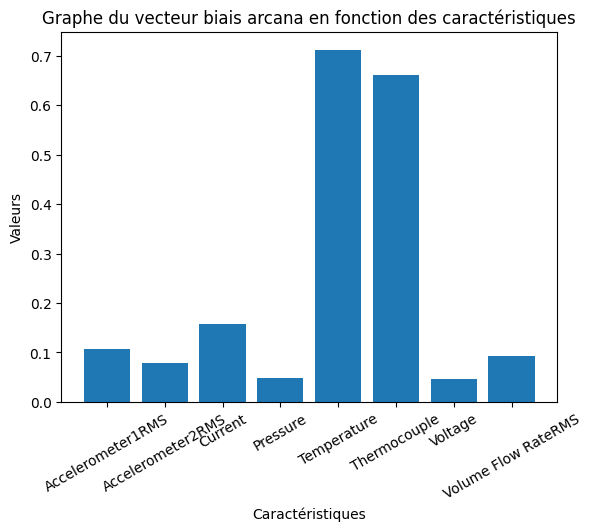

In [94]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur biais arcana en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [95]:
import numpy as np

# Données d'entrée
input_data = np.array([-0.22496596, -0.12444498, -0.19729894, -0.17558487, 0,  0,
 -0.47094131,  0.41109153])
#labels = np.array([64])

# Mise en forme des données pour l'autoencoder
input_data = np.expand_dims(input_data, axis=0)  # Ajouter une dimension de batch
vae.predict(input_data)

reconstructions = vae.predict(input_data)
reconstruction_error = mse(reconstructions, input_data)
pred = reconstruction_error > 0.25
print(reconstruction_error, pred)

1/1 [==============================] - 0s 25ms/step
tf.Tensor([0.10760198], shape=(1,), dtype=float64) tf.Tensor([False], shape=(1,), dtype=bool)


In [98]:
import numpy as np

# Données d'entrée
input_data = np.array([  0.235455,   0,   2.50554,   -0.273216,  0,    0,
 220.781,    129.      ])
#labels = np.array([64])

# Mise en forme des données pour l'autoencoder
input_data = np.expand_dims(input_data, axis=0)  # Ajouter une dimension de batch
vae.predict(input_data)

reconstructions = vae.predict(input_data)
reconstruction_error = mse(reconstructions, input_data)
pred = reconstruction_error > 0.25
print(reconstruction_error, pred)

1/1 [==============================] - 0s 38ms/step
tf.Tensor([6536.09025555], shape=(1,), dtype=float64) tf.Tensor([ True], shape=(1,), dtype=bool)


In [99]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [100]:
import shap
from sklearn.ensemble import RandomForestRegressor

In [101]:
#X_train, X_test, y_train, y_test = ... # Charger les données
model = RandomForestRegressor()
model.fit(train_data_x, train_data_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()

In [102]:
# Créer un explainer Kernel SHAP
explainer = shap.KernelExplainer(vae.predict, train_data_x)

# Calculer les valeurs SHAP pour un échantillon de données de test
shap_values = explainer.shap_values(X_noisy)

625/625 [==============================] - 2s 3ms/step


Using 20000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

158750/158750 [==============================] - 406s 3ms/step


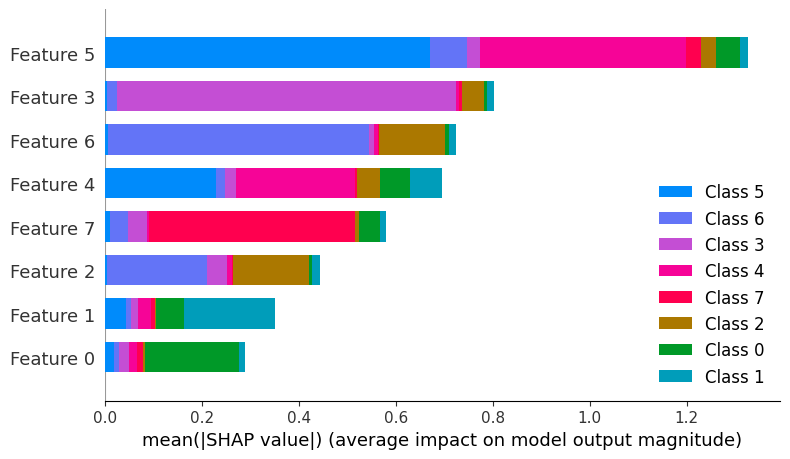

TypeError: list indices must be integers or slices, not tuple

In [103]:
# Afficher un résumé des valeurs SHAP
shap.summary_plot(shap_values, X_noisy)

# Visualiser les valeurs SHAP pour une instance individuelle
shap.force_plot(explainer.expected_value, shap_values[0,:], X_noisy)

In [ ]:
def f(X):
    return vae.predict(X).flatten()

In [ ]:
explainer = shap.KernelExplainer(f, X[:50, :])
shap_values = explainer.shap_values(X[2, :].reshape(1, -1), nsamples=500)
#shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299, :])
print(shap_values)

1/1 [==============================] - 0s 62ms/step


ValueError: operands could not be broadcast together with shapes (80,) (10,) 

In [ ]:
# Compute the estimated Shapley values
index = 0 #choosen instance
observation = X[index,:]
shap_values = explainer.shap_values(observation)


158750/158750 [==============================] - 403s 3ms/step


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
print("Shape of explanation : ",len(shap_values))
shap_values

Shape of explanation :  8


[array([-0.18876247, -0.05314659,  0.01193612, -0.0099429 ,  0.03790415,
        -0.03944325, -0.00084816, -0.05630169]),
 array([ 0.01346349, -0.18037887, -0.00859509,  0.0058338 , -0.06679979,
        -0.03449309, -0.00759622, -0.02620299]),
 array([-0.00879428, -0.00672171,  1.04058927,  0.00215151,  0.00721656,
         0.01747145,  0.19549358, -0.01133748]),
 array([ 0.02593672,  0.01953518,  0.03763357, -0.13762812,  0.0067131 ,
         0.03892073, -0.01220864,  0.05823358]),
 array([-0.01027623,  0.03103629,  0.00107746,  0.00100054, -0.24598407,
         0.43906627, -0.0076073 ,  0.00602113]),
 array([ 0.0238176 ,  0.05525766,  0.01973134,  0.00694709, -0.22496361,
         0.67258799, -0.00320801,  0.03302293]),
 array([ 0.00278257, -0.00380405,  0.04494257,  0.01130579,  0.02485875,
         0.04389595,  0.94794418, -0.01394617]),
 array([ 0.01408563, -0.00846432,  0.00502705,  0.00234633,  0.0048916 ,
        -0.02816393,  0.00454151,  0.41324181])]

In [ ]:
explanation = shap.Explanation(shap_values, data=observation, base_values=explainer.expected_value)#mean(y_train_pred)
print(explanation)

.values =
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

.base_values =
array([1.])

.data =
array([-0.15470175, -0.17561072,  0.98110401, -0.17558487, -0.91891377,
        0.91511187,  1.01520097,  0.37864219])


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Chargez vos données
# data = pd.read_csv('votre_fichier.csv')
# X = data.drop('cible', axis=1)  # Remplacez 'cible' par le nom de votre variable cible
# y = data['cible']

feature_names = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Entraînez votre modèle
model = RandomForestClassifier()
model.fit(X, y)

# Créez un explainer SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Choisissez une observation (par exemple, la première)
observation_index = 0

# Vérifiez le nombre de classes
num_classes = len(shap_values)

# Assurez-vous de sélectionner la bonne classe
if num_classes == 2:
    observation_shap_values = shap_values[1][observation_index]  # Classe positive
else:
    observation_shap_values = shap_values[observation_index]  # Pour multi-classes, choisissez la classe appropriée

# Créez un objet Explanation
expl = shap.Explanation(values=observation_shap_values, 
                        features=X[observation_index], 
                        feature_names=feature_names)

# Créez un barplot
shap.plots.bar(expl)

TypeError: __init__() got an unexpected keyword argument 'features'

.values =
array([0., 0., 0., 0., 0., 0., 0., 0.])

.data =
array([-0.15470175, -0.17561072,  0.98110401, -0.17558487, -0.91891377,
        0.91511187,  1.01520097,  0.37864219])


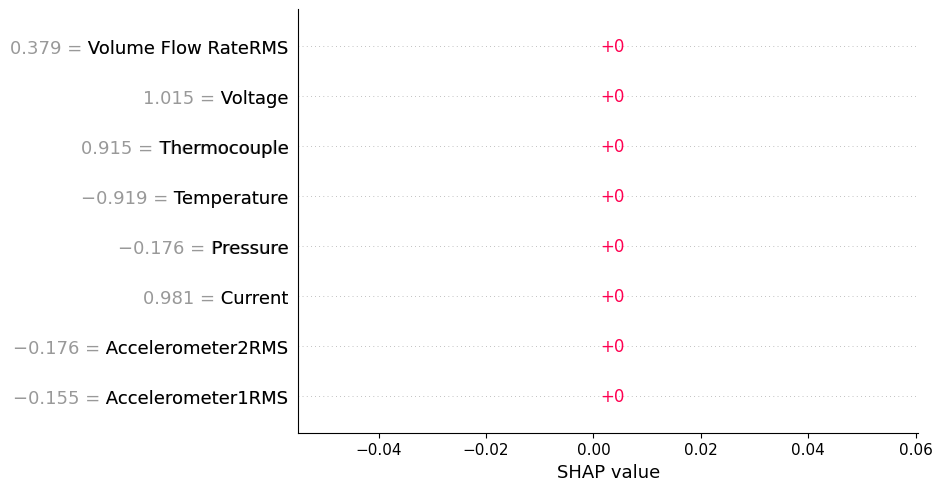

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Chargez vos données
# data = pd.read_csv('votre_fichier.csv')
# X = data.drop('cible', axis=1)  # Remplacez 'cible' par le nom de votre variable cible
# y = data['cible']

feature_names = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Entraînez votre modèle
model = RandomForestClassifier()
model.fit(X, y)

# Créez un explainer SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Choisissez une observation (par exemple, la première)
observation_index = 0

# Vérifiez le nombre de classes
num_classes = len(shap_values)

# Assurez-vous de sélectionner la bonne classe
if num_classes == 2:
    observation_shap_values = shap_values[1][observation_index]  # Classe positive
else:
    observation_shap_values = shap_values[observation_index]  # Pour multi-classes, choisissez la classe appropriée

# Créez un objet Explanation
expl = shap.Explanation(values=observation_shap_values, 
                        data=X[observation_index], 
                        feature_names=feature_names)
print(expl)
# Créez un barplot
shap.plots.bar(expl)